In [1]:
!pip install dask lightgbm xgboost catboost polars scikit-learn --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from lightgbm import LGBMRegressor
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr, kstest, norm
import dask.dataframe as dd

In [3]:
train_path = '/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet'
train_df = dd.read_parquet(train_path)

In [4]:
print("Shape of the dataset:", train_df.shape)
print(train_df.head())

Shape of the dataset: (<dask_expr.expr.Scalar: expr=ReadParquetFSSpec(d60b60b).size() // 93, dtype=int64>, 93)
   date_id  time_id  symbol_id    weight  feature_00  feature_01  feature_02  \
0        0        0          1  3.889038         NaN         NaN         NaN   
1        0        0          7  1.370613         NaN         NaN         NaN   
2        0        0          9  2.285698         NaN         NaN         NaN   
3        0        0         10  0.690606         NaN         NaN         NaN   
4        0        0         14  0.440570         NaN         NaN         NaN   

   feature_03  feature_04  feature_05  ...  responder_0  responder_1  \
0         NaN         NaN    0.851033  ...     0.738489    -0.069556   
1         NaN         NaN    0.676961  ...     2.965889     1.190077   
2         NaN         NaN    1.056285  ...    -0.864488    -0.280303   
3         NaN         NaN    1.139366  ...     0.408499     0.223992   
4         NaN         NaN    0.955200  ...    -0

In [5]:
missing_percentage = train_df.isnull().mean().compute() * 100
high_missing_columns = missing_percentage[missing_percentage > 5].index.tolist()

In [6]:
from dask import delayed, compute
from dask.dataframe import repartition

# Step 1: Identify columns with >5% missing values for selective KNN imputation
missing_percentage = train_df.isnull().mean().compute() * 100
high_missing_columns = missing_percentage[missing_percentage > 5].index.tolist()

# Step 2: Quick forward and backward fill for general missing values
train_df = train_df.fillna(0)

# Step 3: Selective KNN imputation for columns with high missing values
if high_missing_columns:
    chunk_size = 100000  # Adjust chunk size based on memory availability
    train_df = train_df.repartition(npartitions=int(train_df.shape[0].compute() / chunk_size))

    def knn_impute_partition(df_partition):
        imputer = KNNImputer(n_neighbors=5)
        imputed = imputer.fit_transform(df_partition[high_missing_columns])
        df_partition[high_missing_columns] = imputed
        return df_partition

    delayed_results = [delayed(knn_impute_partition)(df_partition) for df_partition in train_df.to_delayed()]
    train_df_imputed = dd.from_delayed(delayed_results)

print("Missing values handled using selective KNN imputation.")


Missing values handled using selective KNN imputation.


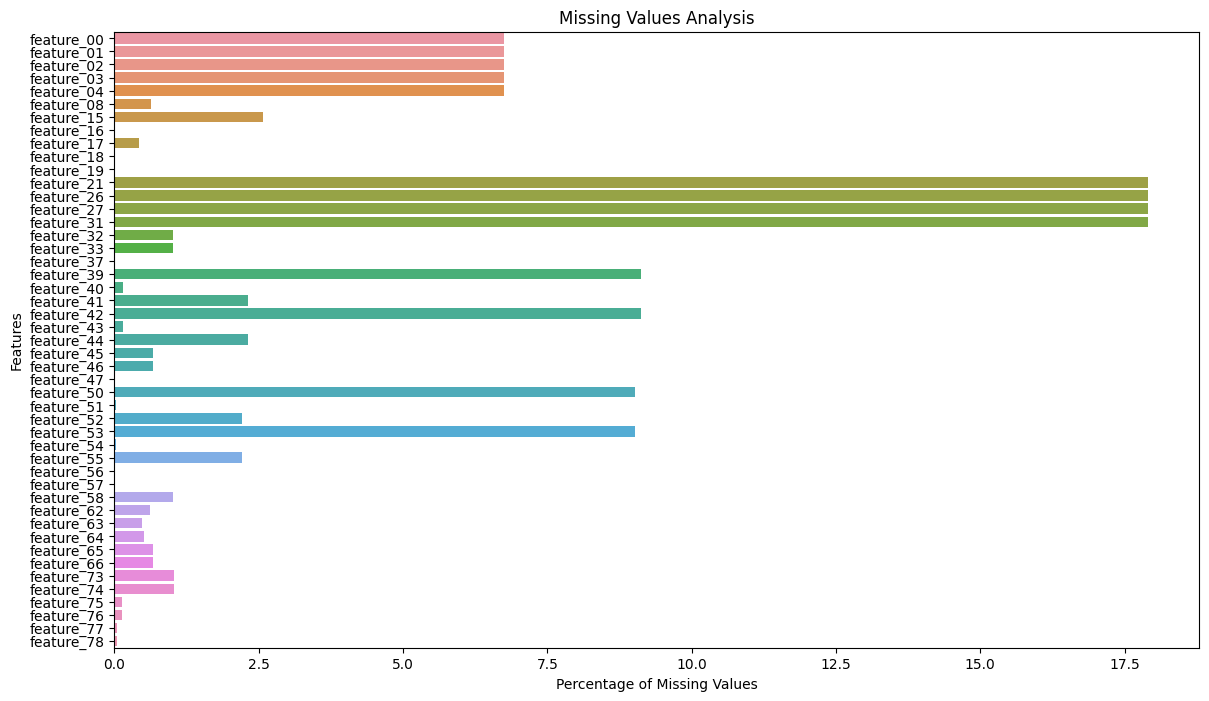

In [7]:
missing_data_filtered = missing_percentage[missing_percentage > 0]
plt.figure(figsize=(14, 8))
sns.barplot(x=missing_data_filtered.values, y=missing_data_filtered.index)
plt.title("Missing Values Analysis")
plt.xlabel("Percentage of Missing Values")
plt.ylabel("Features")
plt.show()

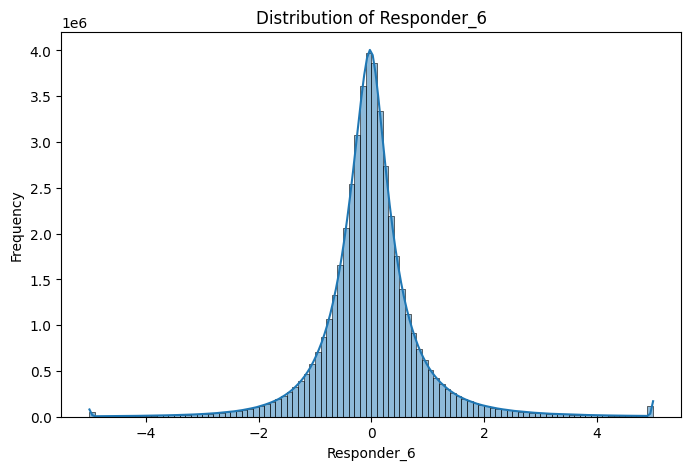

In [8]:
plt.figure(figsize=(8, 5))
sns.histplot(train_df['responder_6'].compute(), bins=100, kde=True)
plt.title("Distribution of Responder_6")
plt.xlabel("Responder_6")
plt.ylabel("Frequency")
plt.show()

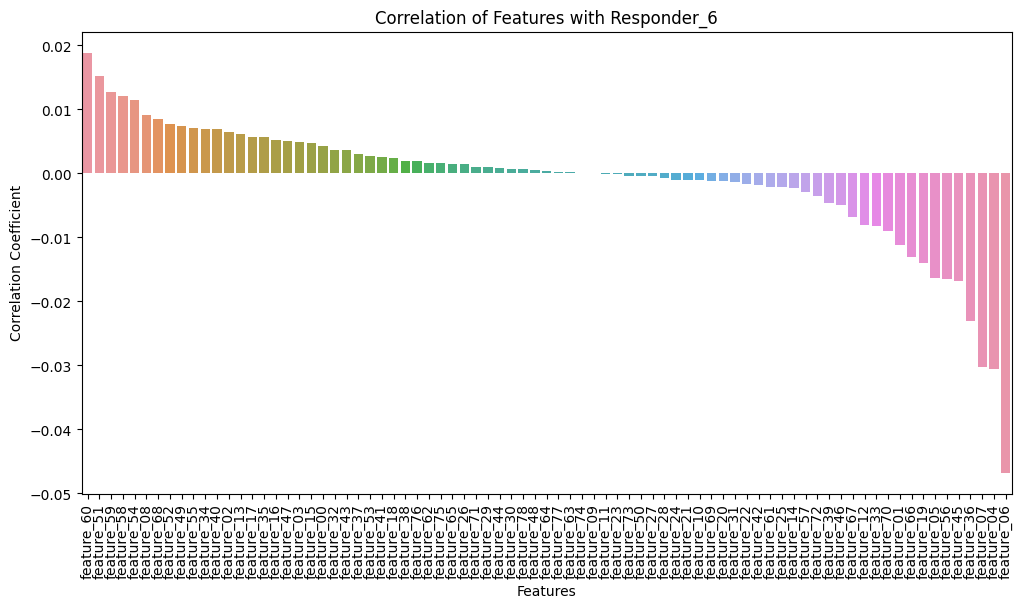

In [9]:
#///////////
feature_columns = [col for col in train_df.columns if 'feature' in col]
correlation_with_responder = train_df[feature_columns + ['responder_6']].corr().compute()
responder_corr = correlation_with_responder['responder_6'].drop('responder_6').sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=responder_corr.index, y=responder_corr.values)
plt.xticks(rotation=90)
plt.title("Correlation of Features with Responder_6")
plt.xlabel("Features")
plt.ylabel("Correlation Coefficient")
plt.show()

In [10]:
selected_features = responder_corr[responder_corr.abs() > 0.02].index.tolist()
print("Selected features for modeling:", selected_features)

Selected features for modeling: ['feature_36', 'feature_07', 'feature_04', 'feature_06']


In [11]:
X = train_df[selected_features].compute()
y = train_df['responder_6'].compute()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
lgb_model = LGBMRegressor(random_state=42)
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.060847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 37701870, number of used features: 4
[LightGBM] [Info] Start training from score -0.002107


LGBMRegressor(random_state=42)

In [13]:
baseline_mse = mean_squared_error(y_test, lgb_model.predict(X_test))
print(f"Baseline MSE: {baseline_mse}")

Baseline MSE: 0.7887084110153441


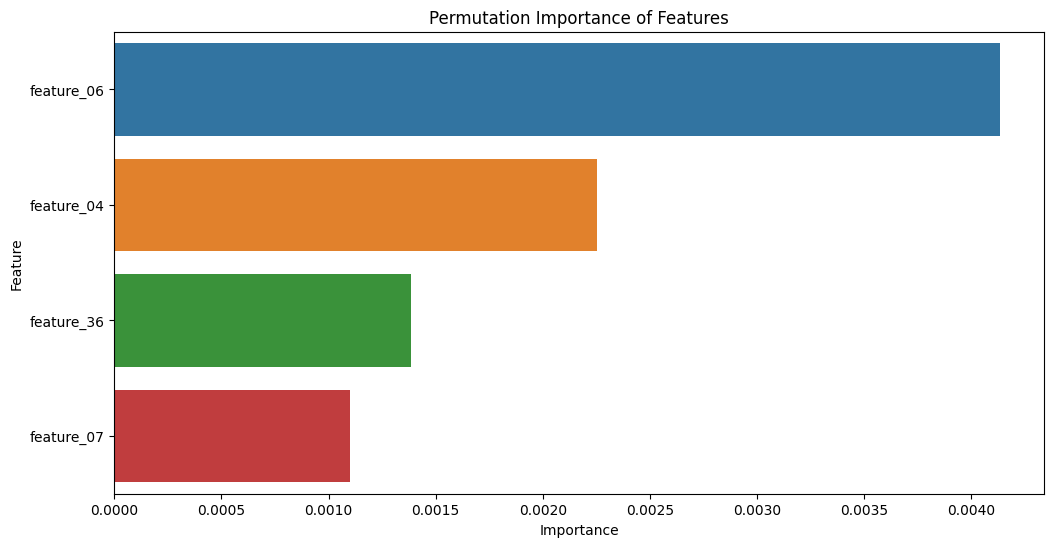

Permutation Importance Results:
      Feature  Importance   Std_Dev
3  feature_06    0.004134  0.000031
2  feature_04    0.002253  0.000031
0  feature_36    0.001384  0.000018
1  feature_07    0.001102  0.000020


In [14]:
perm_importance = permutation_importance(lgb_model, X_test, y_test, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_importance.importances_mean,
    'Std_Dev': perm_importance.importances_std
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=perm_importance_df)
plt.title("Permutation Importance of Features")
plt.show()

print("Permutation Importance Results:")
print(perm_importance_df)

In [15]:
mean_responder = y.mean()
std_responder = y.std()
ks_statistic, p_value = kstest(y, 'norm', args=(mean_responder, std_responder))
print(f"KS Test Statistic: {ks_statistic:.9f}")
print(f"P-value: {p_value:.9e}")

if p_value > 0.05:
    print("Fail to reject H0: The data appears to follow a normal distribution.")
else:
    print("Reject H0: The data does not follow a normal distribution.")

KS Test Statistic: 0.105132970
P-value: 0.000000000e+00
Reject H0: The data does not follow a normal distribution.


In [16]:
X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            responder_6   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                 3.726e+04
Date:                Wed, 08 Jan 2025   Prob (F-statistic):               0.00
Time:                        17:57:17   Log-Likelihood:            -6.1297e+07
No. Observations:            47127338   AIC:                         1.226e+08
Df Residuals:                47127333   BIC:                         1.226e+08
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.000    -17.783      0.0

In [17]:
perm_importance_df.to_csv('permutation_importance_results.csv', index=False)
model_summary = model.summary().as_text()
with open('regression_analysis_summary.txt', 'w') as f:
    f.write(model_summary)

print("Analysis complete and results saved.")


Analysis complete and results saved.
